# Summary table

| Method           | Lower outlier threshold | Upper outlier threshold | pct of outliers |
|------------------|-------------------------|-------------------------|-----------------|
| Z-score 3 std    |                         |                         |                 |
| Box plot 1.5 IQR |                         |                         |                 |
| Box plot 3 IQR   |                         |                         |                 |
| Cook's distance  | -                       | -                       |                 |



# Imports

In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns

#increase font size of all elements
sns.set(font_scale=1.5)


# Load the data

In [28]:
import os
import requests

# Data can be found at https://www.kaggle.com/datasets/mustafaali96/weight-height and also at the following url
url = "https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv"

def download_data(url, force_download=False, **read_csv_kwargs):
    # Donwload data if it is not in disk
    data_path = os.path.join('data', os.path.basename(url.split('?')[0]))
    if not os.path.exists(data_path) or force_download:
        # ensure data dir is created
        os.makedirs('data', exist_ok=True)
        # request data from url
        response = requests.get(url, allow_redirects=True)
        # save file
        with open(data_path, "w") as f:
            # Note the content of the response is in binary form: 
            # it needs to be decoded.
            # The response object also contains info about the encoding format
            # which we use as argument for the decoding
            f.write(response.content.decode(response.apparent_encoding))
    print(f"File saved to {data_path}")

download_data(url)


File saved to data\weight-height.csv


In [29]:
# read csv file
data = pd.read_csv('data/weight-height.csv')
#Convert inches/pounds to m/kg
data.loc[:, 'Weight'] /= 2.205
data.loc[:, 'Height'] /= 39.37

# visualize the first 5 rows
data.head()


,Gender,Height,Weight
0,Male,1.875718,109.702296
1,Male,1.747064,73.610192
2,Male,1.882400,96.481114
3,Male,1.821970,99.792504
4,Male,1.775001,93.582676


# Plot histograms


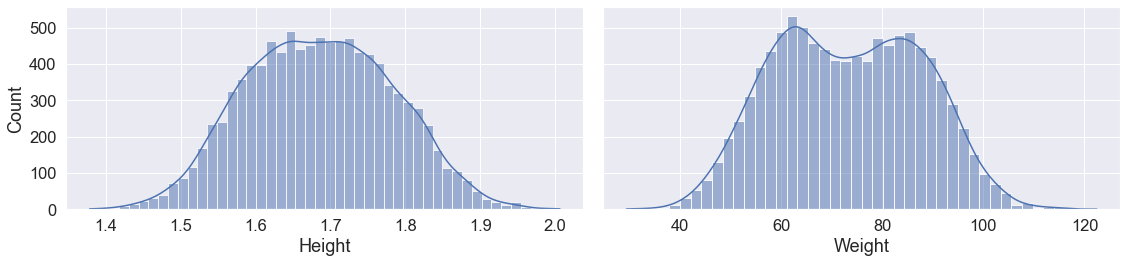

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,4))
sns.histplot(data=data, x='Height', kde=True, ax=ax1)
sns.histplot(data=data, x='Weight', kde=True, ax=ax2)
fig.tight_layout()

<AxesSubplot:xlabel='Weight', ylabel='Count'>

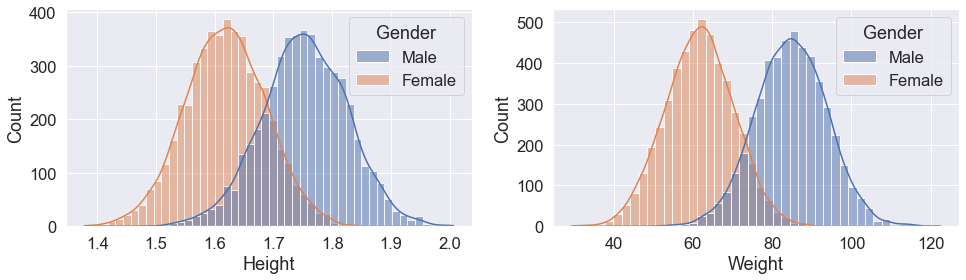

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
sns.histplot(data=data, x='Height', hue='Gender', kde=True, ax=ax1)
sns.histplot(data=data, x='Weight', hue='Gender', kde=True, ax=ax2)

In [32]:
dataF = data.query("Gender=='Female'")
dataM = data.query("Gender=='Male'")

# Print basic statistics wtih `describe`


In [33]:
display(data.describe())

,Height,Weight
count,10000.000000,10000.000000
mean,1.685739,73.215581
std,0.097727,14.561650
min,1.378286,29.342461
25%,1.613046,61.595488
50%,1.684482,73.112439
75%,1.757030,84.884138
max,2.006572,122.444308


In [34]:
data.groupby('Gender').describe().T

Gender             Female         Male
Height count  5000.000000  5000.000000
       mean      1.618206     1.753273
       std       0.068486     0.072730
       min       1.378286     1.483538
       25%       1.572122     1.706240
       50%       1.618769     1.753307
       75%       1.665318     1.803118
       max       1.864099     2.006572
Weight count  5000.000000  5000.000000
       mean     61.614555    84.816608
       std       8.626970     8.971045
       min      29.342461    51.203147
       25%      55.752425    78.860665
       50%      61.731330    84.822470
       75%      67.487948    90.865216
       max      91.717557   122.444308

# Z-score

In [35]:
from scipy.stats import zscore
# help(zscore)

## Outlier ratio

In [96]:
data_with_z = data.join(data[['Height', 'Weight']].apply(zscore), rsuffix='_z_score')

is_outlier_H = (data_with_z.Height_z_score.abs() > 3)
is_outlier_W = (data_with_z.Weight_z_score.abs() > 3)


display(f'Height outlier count: {is_outlier_H.sum():d}/{data.shape[0]}'
f' ({is_outlier_H.mean()*100:0.5f}%)')

'Height outlier count: 7/10000 (0.07000%)'

**Note**: z-score can also be applied by group:

In [36]:
data.join(data.groupby('Gender').apply(zscore), rsuffix='_z_score')

,Gender,Height,Weight,Height_z_score,Weight_z_score
0,Male,1.875718,109.702296,1.683739,2.774278
1,Male,1.747064,73.610192,-0.085377,-1.249301
2,Male,1.882400,96.481114,1.775629,1.300369
3,Male,1.821970,99.792504,0.944660,1.669526
4,Male,1.775001,93.582676,0.298787,0.977249
...,...,...,...,...,...
9995,Female,1.680789,62.030591,0.913897,0.048230
9996,Female,1.703509,77.491114,1.245684,1.840524
9997,Female,1.622250,58.265451,0.059057,-0.388252
9998,Female,1.753473,74.309506,1.975312,1.471690


# Box-plots + interquartile range


## Whiskers at 1.5 IQR

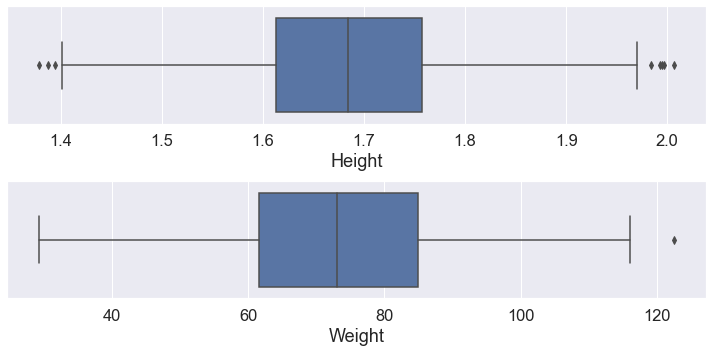

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
sns.boxplot(data=data, x='Height',orient='horiz', ax=ax1)
sns.boxplot(data=data, x='Weight',orient='horiz', ax=ax2)
fig.tight_layout()

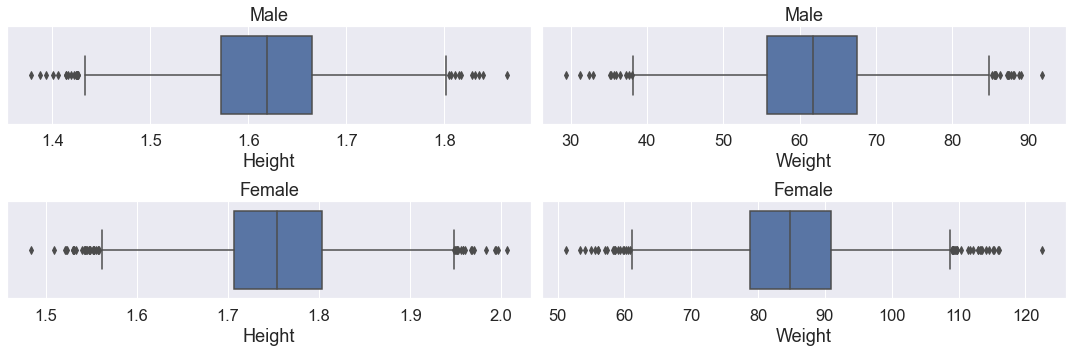

In [10]:
fig, axs = plt.subplots(2,2, figsize=(15,5))
for i, (df, group) in enumerate(zip([dataF, dataM], ['Male', 'Female'])):
    for j, col in enumerate(['Height', 'Weight']):
        ax = axs[i][j]
        ax.set_title(group)
        sns.boxplot(data=df, x=col, ax=ax)
fig.tight_layout()

## Whiskers at 3 IQR

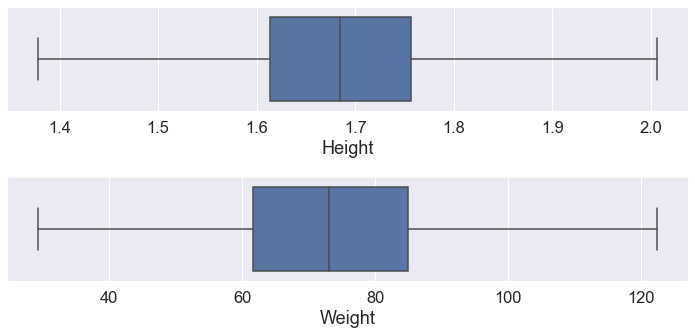

In [78]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
sns.boxplot(data=data, x='Height',orient='horiz', whis=3, ax=ax1)
sns.boxplot(data=data, x='Weight',orient='horiz', whis=3, ax=ax2)
fig.tight_layout()

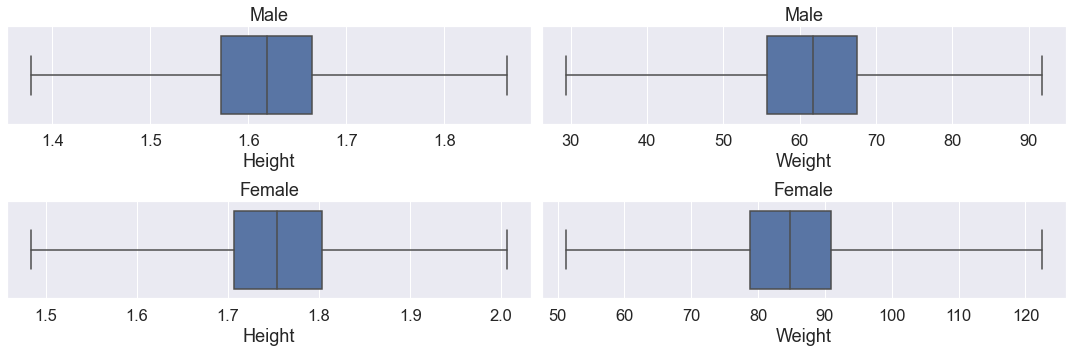

In [13]:
fig, axs = plt.subplots(2,2, figsize=(15,5))
for i, (df, group) in enumerate(zip([dataF, dataM], ['Male', 'Female'])):
    for j, col in enumerate(['Height', 'Weight']):
        ax = axs[i][j]
        ax.set_title(group)
        sns.boxplot(data=df, x=col, ax=ax, whis=3)
fig.tight_layout()

## Outlier ratio

In [79]:
q1 = data.quantile(0.25, interpolation='nearest')
q3 = data.quantile(0.75, interpolation='nearest')
IQR = q3-q1
IQR

Height     0.143959
Weight    23.285521
dtype: float64

In [81]:
k = 1.5
lower, upper = q1-k*IQR, q3+k*IQR
lower, upper

(Height     1.397114
 Weight    26.667679
 dtype: float64,
 Height      1.972952
 Weight    119.809765
 dtype: float64)

In [87]:
maskh = data.Height > upper.loc['Height'] 
maskl = data.Height < lower.loc['Height']
display(f'Outlier count: {(maskh | maskl).sum():d}/{data.shape[0]}',
f'Outlier ratio: {(maskh | maskl).mean()*100:0.5f}%')


'Outlier count: 8/10000'

'Outlier ratio: 0.08000%'

### By group

In [50]:
q1 = data.groupby('Gender').quantile(0.25, interpolation='nearest')
q3 = data.groupby('Gender').quantile(0.75, interpolation='nearest')
IQR = q3-q1
IQR

,Height,Weight
Gender,,
Female,0.093184,11.731748
Male,0.096843,12.003873


In [76]:
k = 1.5
lower, upper = q1-k*IQR, q3+k*IQR
lower.loc['Female','Height'], upper.loc['Female','Height'] 

(1.432352536448143, 1.8050887169575263)

In [ ]:
maskh = dataF.Height > upper.loc['Female','Height'] 
maskl = dataF.Height < lower.loc['Female','Height']
f'Outlier ratio: {(maskh | maskl).mean()*100:0.5f}%'


'Outlier ratio: 0.54000%'

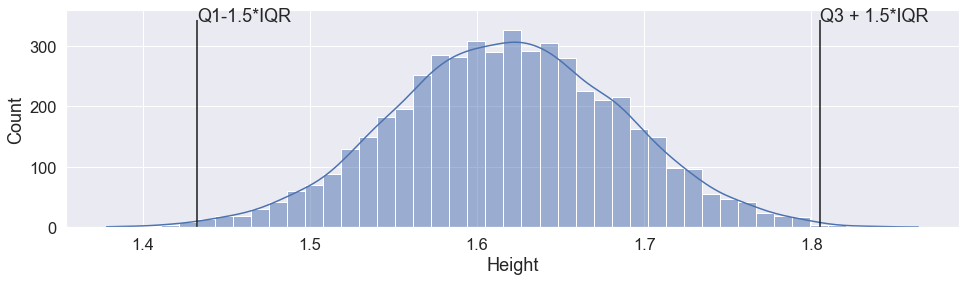

In [47]:
group = 'Female'
col = 'Height'

plt.figure(figsize=(16, 4))
sns.histplot(data=data.query(f"Gender=='{group}'"), x=col, kde=True)
lo, up = lower.loc[group, col], upper.loc[group, col]
_, ymax = plt.gca().get_ylim()
plt.vlines([lo, up], 0, ymax, colors='k')
plt.annotate(f'Q1-{k}*IQR',(lo,ymax))
plt.annotate(f'Q3 + {k}*IQR',(up,ymax))
plt.show()

# Regression based methods

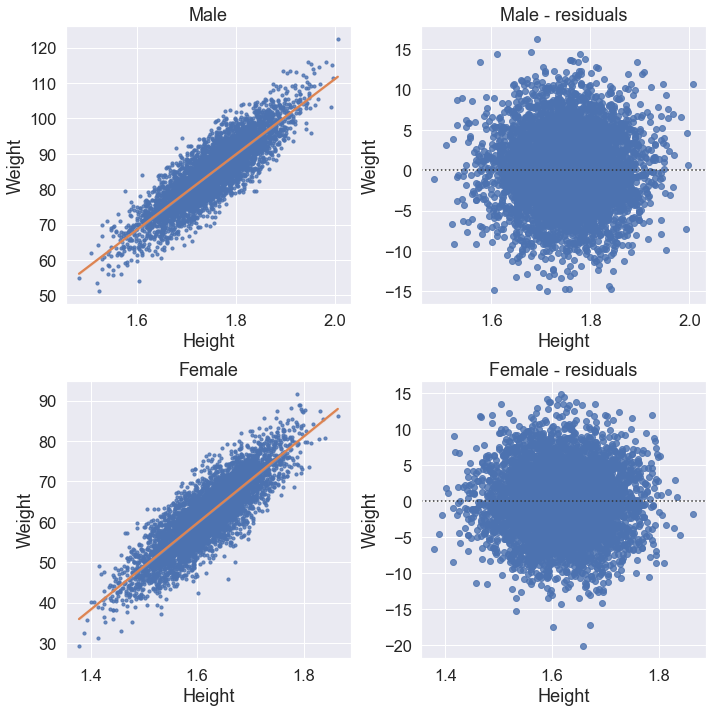

In [11]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
for i, group in enumerate(['Male', 'Female']):
        ax = axs[i][0]
        ax.set_title(group)
        sns.regplot(
                data=data.query(f"Gender=='{group}'"), x='Height', y='Weight',
                line_kws={"color": "C1"}, scatter_kws={"s": 10}, ax=ax)
        ax = axs[i][1]
        ax.set_title(f'{group} - residuals')
        sns.residplot(
        data=data.query(f"Gender=='{group}'"), x='Height', y='Weight',
        ax=ax)
fig.tight_layout()

## Cook's distance


At threshold 4/N = 0.00080, 256 samples are considered outliers (5.12% of the samples)


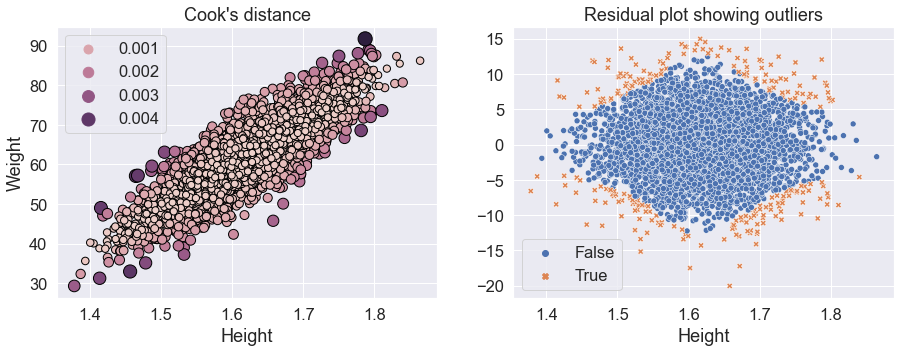

In [12]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence

# fit the regression model using statsmodels library
f = 'Weight ~ Height'
model = ols(formula=f, data=dataF).fit()

# calculate the cooks_distance - the OLSInfluence object contains multiple influence measurements
cook_distance = OLSInfluence(model).cooks_distance
(distance, p_value) = cook_distance

threshold = 4/dataF.shape[0]
is_outlier = distance > threshold
print(f'At threshold 4/N = {threshold:0.5f}, '
      f'{is_outlier.sum()} samples are considered outliers '
      f'({is_outlier.mean()*100:0.2f}% of the samples)')

# scatter plot - x axis (independent variable height), y-axis (dependent variable weight), size and color of the marks according to its cook's distance
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title('Cook\'s distance')
sns.scatterplot(data=dataF, x="Height", y="Weight",
                hue=distance, size=distance, ax=axs[0],
                sizes=(50, 200), edgecolor='black', linewidth=1)


axs[1].set_title('Residual plot showing outliers')
sns.scatterplot(data=dataF, x="Height", y=model.resid, ax=axs[1],
                style=is_outlier, hue=is_outlier)
plt.show()
